Trong thực tế việc kết hợp nhiều mô hình dự đoán (regressors hoặc classifiers), ta thường thu được kết quả tốt hơn một mô hình dự đoán đơn lẻ. Một nhóm của mô hình dự đoán đó được gọi là `ensemble` (quần thể), công nghệ này được gọi là `ensemble learning` (học tổng hợp), và một thuật toán học tổng hợp được gọi là `ensemble method`

Một ví dụ của `ensemble method`, ta có thể huấn luyện một nhóm `decision tree classifiers`, mỗi mô hình trên một bộ dữ liệu con ngẫu nhiên. Ta sẽ thu được các dự đoán của từng cây, và nhãn là lớp được dự đoán nhiều nhất. Như vậy một nhóm các cây quyết định được gọi là một `random forest`, mặc dù có vẻ đơn giản, đây là một trong những thuật toán học máy mạnh mẽ nhất hiện nay.

# Voting Classifiers

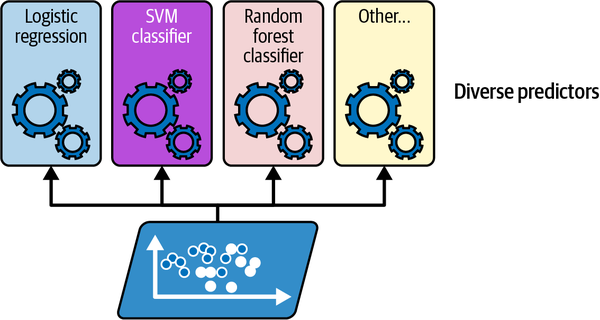

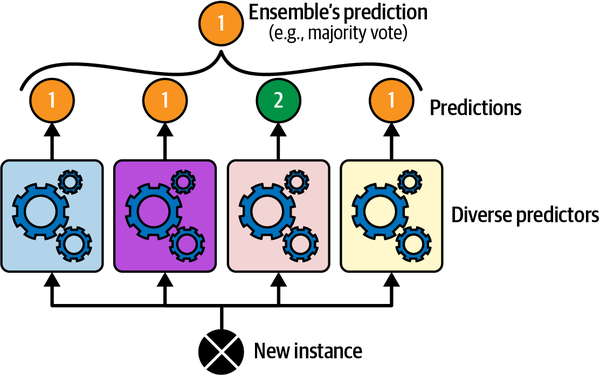

Giả sử một bộ phân loại được cấu thành từ nhiều bộ phân loại con khác, khi dự đoán kết quả là đa số kết quả của các bộ phân loại con điều này gọi là `hard voting` classifier

Một cách thần kì, voting classifier thường đạt được độ chính xác tốt hơn bộ phân loại tốt nhất trong cụm. Thực vậy, mặc dù mỗi classifier là một `weak learner` (tức là nó chỉ tốt hơn đoán ngẫu nhiên một chút), cụm này vẫn có thể là một `strong learner` (độ chính xác cao) miễn là số weak learner đủ nhiều và đa dạng.

In [26]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(random_state=42))
    ]
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [27]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, "=", clf.score(X_test, y_test))

lr = 0.864
rf = 0.896
svc = 0.896


In [28]:
voting_clf.score(X_test, y_test)

0.912

Nếu các classifiers có thể dự đoán xác suất, ta có thể dự đoán theo xác suất cao nhất, gọi là `soft voting`. Nó thường có hiệu suất tốt hơn `hard voting` bởi nó cùng cấp nhiều trọng số hơn để dự đoán.

In [29]:
voting_clf.voting = 'soft'
voting_clf.named_estimators["svc"].probability = True
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.92

# Bagging and Pasting

Một cách để có được một tập hợp đa dạng các bộ phân loại là sử dụng các thuật toán huấn luyện rất khác nhau. Một cách tiếp cần khác là sử dụng một loại thuật toán huấn luyện cho tất cả các bộ dự đoán nhưng đào tạo chúng trên các tập con ngẫu nhiên khác nhau của training set.

Khi việc lấy mẫu được thực hiện có hoàn lại (tức là một mẫu có thể bị lấy nhiều lần), phương pháp này được gọi là `bagging` (viết tắt của bootstrap aggregating). Khi lấy mẫu không hoàn lại thì được gọi là `pasting`. 

Nói cách khác, cả bagging và pasting đều cho phép các mẫu huấn luyện được chọn nhiều lần giữa các bộ dự đoán khác nhau, nhưng chỉ bagging mới cho phép một mẫu huấn luyện được chọn nhiều lần trong cùng một bộ dự đoán.

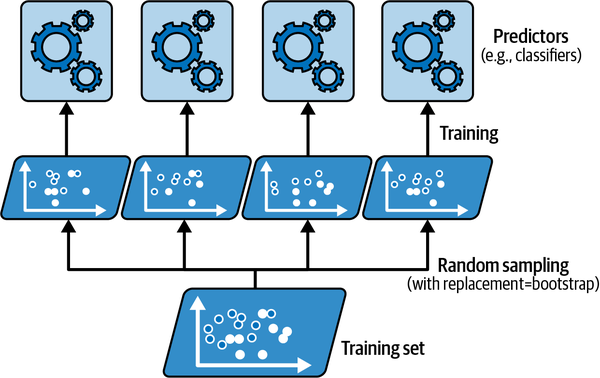

Khi tất cả các bộ dự đoán được huấn luyện, cụm có thể dự đoán một instance mới bằng cách kết hợp các dự đoán của bộ dự đoán. Hàm kết hợp thường được sử dụng là thống kê (statistical mode) cho phân loại, hoặc trung bình cho hồi quy. Mỗi bộ dự đoán riêng lẻ sẽ có độ lệch (bias) cao hơn so với khi nó được huấn luyện trên toàn bộ tập huấn luyện gốc, nhưng việc tổng hợp (aggregation) giúp giảm cả bias và phương sai (variance).
Nhìn chung, kết quả cuối cùng là mô hình tổ hợp (ensemble) có độ lệch tương đương nhưng phương sai thấp hơn so với một bộ dự đoán đơn lẻ được huấn luyện trên tập huấn luyện gốc.

Từ hình trên có thể thấy các bộ dự đoán có thể được huấn luyện song song cùng một lúc. Đó là lí do tại sao bagging và pasting được sử dụng phổ biến, vì nó có thể mở rộng rất tốt.

## Bagging and Pasting

In [30]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# n_estimators: number of ensemble model
# max_samples: instances randomly sampled from training set
# n_jobs: number of Cpu core is used (-1 for all)
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, 
                            max_samples=100, n_jobs=-1, random_state=42)

bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

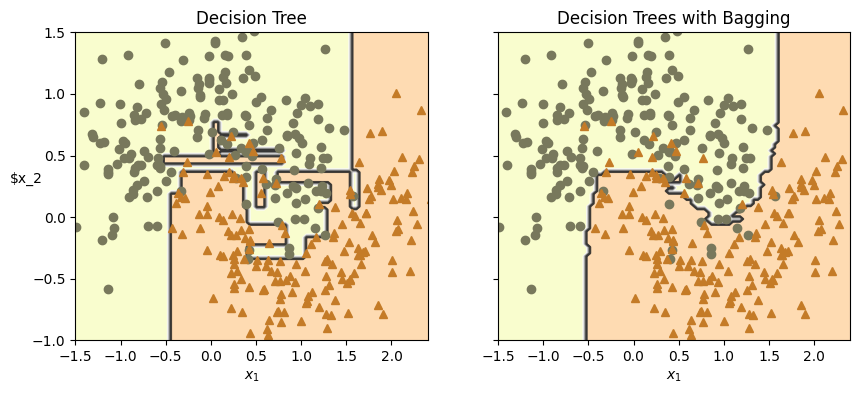

In [31]:
import numpy as np
import matplotlib.pyplot as plt

def plot_decision_boundary(clf, X, y, alpha=1.0):
    axes=[-1.5,  2.4, -1, 1.5]
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))

    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)

    plt.contourf(x1, x2, y_pred, alpha=0.3 * alpha, cmap='Wistia')
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8 * alpha)
    colors = ["#78785c", "#c47b27"]
    markers = ("o", "^")

    for idx in (0, 1):
        plt.plot(X[:,0][y == idx], X[:, 1][y == idx], 
                 color=colors[idx], marker=markers[idx], linestyle='none')
    plt.axis(axes)
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2', rotation=0)

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train,  y_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X_train, y_train)
plt.title("Decision Tree")
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X_train, y_train)
plt.title("Decision Trees with Bagging")
plt.ylabel("")
plt.show()

## Out-of-Bag Evaluation

Với phương pháp bagging, một số instances có thể được lấy mẫu nhiều lần và một số instances có thể không được lấy, những instances này được gọi là *out-of-bag (OOB)*

Một cụm bagging có thể được đánh giá bằng các OOB instances, mà không cần các bộ đánh giá riêng biệt khác, thực sự, nếu có đủ các ước tính, thì mỗi trường hợp trong tập huấn luyện có khả năng sẽ là một trường hợp OOB của một số ước tính, do đó, các ước tính này có thể được sử dụng để đưa ra dự đoán tập hợp công bằng cho trường hợp đó. Khi bạn có dự đoán cho từng trường hợp, bạn có thể tính toán độ chính xác dự đoán của tập hợp (hoặc bất kỳ số liệu nào khác).

In [32]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, 
                            oob_score=True, n_jobs=1, random_state=42)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

# likely to achieve about 89.6% accuracy on the test set

0.896

In [33]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_pred, y_test)

# the real metric

0.92

## Random Patches and Random Subspaces

BaggingClassifierd cũng hỗ trợ lấy mẫu các feature. Được điều khiển bởi 2 siêu tham số là `max_features` và `boostrap_features` (Tương tự `max_samples` và `bootstrap`). Sau đó các mỗi bộ dự đoán sẽ được huấn luyện trên các tập con ngẫu nhiên của các `input features`

Kĩ thuật này hữu ích nếu phải xử lí các đầu vào nhiều chiều (ví dụ như ảnh), giúp tăng tốc quá trình huấn luyện. 

Lấy mẫu cả training instances và features được gọi là `random patches` method. 

Giữ nguyên training instances thực hiện lấy mẫu với features thì được gọi là `random subspaces` method.

# Random Forests

Random forests là một cụm các decision trees, thường được huấn luyện bởi phương pháp bagging (hoặc thỉnh thoảng là pasting), bình thường `max_samples` được cài đặt bằng với kích thước của tập huấn luyện. Thay vì xây dựng một `BaggingClassifer` và truyền vào một `DecisionTreeClassifier`, ta có thể dùng `RandomForestClassifier`, nó tiện và tối ưu hơn.

In [34]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, 
                                n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

Trừ một số ngoại lệ, một `RandomForestClassifier` có tất cả hyperparameters của một `DecisionTreeClassifier` (để điều khiển sự phát triển của cây), và tất cả các hyperparameters của `BaggingClassifier` để điều khiển cụm.

Thuật toán random forest giới thiệu đưa thêm các tính ngẫu nhiên khi phát triển cây, thay vì tìm kiếm tính năng tốt nhất khi chia tách một nút, nó tìm kiếm feature tốt nhất giữa các tập con features ngẫu nhiên. Theo mặc định, nó lấy $\sqrt n$ features (n là tổng số các feature). Thuật toán này tạo ra sự đa dạng cao hơn giữa các cây (đánh đổi độ lệch (bias) - để giảm phương sai (variance)), và thường mang lại một mô hình tổng thể tốt hơn. Vì vậy, `BaggingClassifier` sau đây là tương đương với `RandomForestClassifier` trước đó:

In [35]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, n_jobs=-1, random_state=42)

## Extra-Trees

Khi xây dựng một cây trong random forest, tại mỗi nút chỉ một tập con ngẫu nhiên của các features được xem xét để phân chỉa. Ta có thể làm cho các cây trở nên ngẫu nhiên hơn nữa bằng cách sử dụng ngưỡng phân chia ngẫu nhiên cho từng đặc trưng, thay vì tìm kiếm ngưỡng tốt nhất có thể (giống như cây quyết định thông thường làm). Để làm điều này, chỉ cần đặt `splitter="random"` khi tạo một `DecisionTreeClassifier`

Một rừng gồm các cây cực kỳ ngẫu nhiên như vậy được gọi là một tập hợp các cây **cực kỳ ngẫu nhiên** (`extremely randomized trees` hoặc gọi tắt là `extra-trees`). Ngoài ra, các mô hình phân loại sử dụng extra-trees còn có tốc độ huấn luyện nhanh hơn nhiều so với random forest thông thường, vì việc tìm ngưỡng tối ưu cho từng đặc trưng tại mỗi nút là một tác vụ tốn thời gian nhất trong quá trình xây dựng cây

## Feature Importance

Một ưu điểm khác của RandomForest là ta có thể đo lường tầm quan trọng tương đối của từng đặc trưng dễ dàng hơn. Scikit-learn đo tầm quan trọng của một đặc trưng bằng cách xem xét mức độ trung bình mà các nút trong cây sử dùng đặc trưng đó để giảm độ nhiễu (impurity). Cụ thể hơn, đây là một trung bình có trọng số, trong đó trọng số của mỗi nút bằng với số lượng mẫu huấn luyện liên quan đến nút đó.

Scikit-Learn tính điểm quan trọng tự động cho mỗi feature sau quá trình huấn luyện, sau đó nó chuẩn hóa kết quả sao cho tổng bằng 1.

In [36]:
from sklearn.datasets import load_iris
iris = load_iris(as_frame=True)
rnd_clf = RandomForestClassifier(n_estimators=500,  random_state=42)
rnd_clf.fit(iris.data, iris.target)
for score, name in zip(rnd_clf.feature_importances_, iris.data.columns):
    print(round(score, 2), name)

0.11 sepal length (cm)
0.02 sepal width (cm)
0.44 petal length (cm)
0.42 petal width (cm)


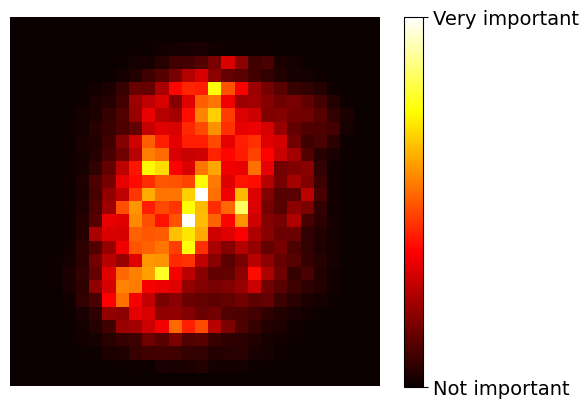

In [37]:
from sklearn.datasets import fetch_openml

X_mnist, y_mnist = fetch_openml('mnist_784', return_X_y=True, as_frame=False, parser='auto')

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(X_mnist, y_mnist)

heatmap_image = rnd_clf.feature_importances_.reshape(28, 28)
plt.imshow(heatmap_image, cmap='hot')
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(),
                           rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'], fontsize=14)
plt.axis('off')
plt.show()

# Boosting

Boosting (tên gốc là *hypothesis boosting*) đề cập đến bất kỳ phương pháp tổ hợp (ensemble) nào có thể kết hợp nhiều mô hình học yếu thành một mô hình học mạnh. Ý tưởng chung của hầu hết các phương pháp boosting là huấn luyện các bộ dự đoán một cách tuần tự, trong đó mỗi bộ dự đoán cố gắng sửa lỗi của bộ dự đoán trước đó.

Có rất nhiều các phương pháp boosting khác nhau, nhưng phổ biến nhất cho đến nay là **AdaBoost** (adaptive boosting) và **gradient boosting**

## AdaBoost

Một cách để bộ dự đoán mới sửa lỗi của bộ dự đoán trước đó là chú ý nhiều hơn đến các mẫu huấn luyện mà bộ trước đã học chưa tốt (underfit). Điều này dẫn đến việc các bộ dự đoán mới dần dần tập trung nhiều hơn vào các trường hợp khó. Đây chính là kỹ thuật được sử dụng trong AdaBoost.

Ví dụ khi huấn luyện một AdaBoost classifiers, trước tiên thuật toán huấn luyện với một bộ phân loại cơ bản (ví dụ decision tree) và sử dụng nó để dự đoán trên tập training. Sau đó thuật toán sẽ tăng trọng số tương đối của các mẫu huấn luyện bị dự đoán sai. Tiếp theo nó huấn luyện một bộ phân loại thứ hai, sử dụng dụng các trọng số đã được cập nhất, lặp lại các bước như trên. được minh họa bởi hình sau

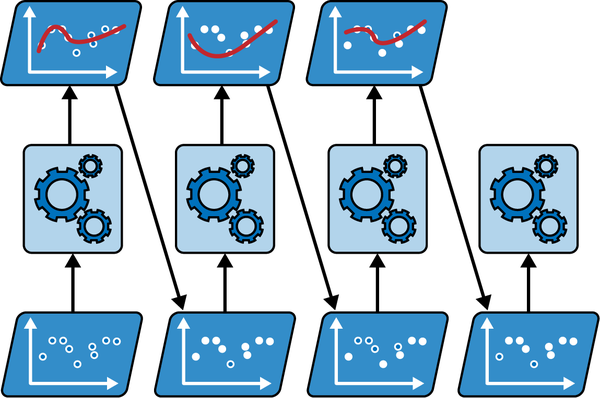

Khi tất cả các bộ dự đoán đã được huấn luyện, tổ hợp (ensemble) sẽ thực hiện việc dự đoán tương tự như các phương pháp bagging hoặc pasting, ngoại trừ việc các bộ dự đoán sẽ có trọng số khác nhau tùy thuộc vào độ chính xác tổng thể của chúng trên tập huấn luyện có trọng số.

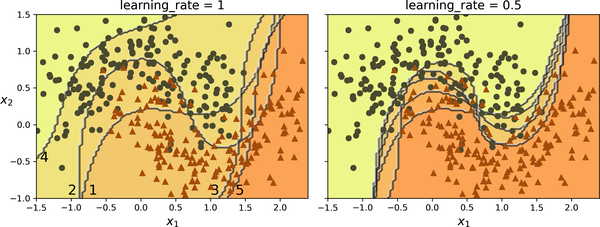

Hình trên biểu diễn 5 bộ dự đoán liên tiếp trên bộ moons dataset. Với bộ dữ đoán đầu tiên, trọng số được tăng lên. Do đó bộ dự đoán thứ hai thực hiện tốt hơn với các trường hợp này. Tiếp tục cho đến hết

Hình bên phải có learning_rate bằng một nửa (trọng số cập nhật một lần chỉ bằng một nửa). Phương pháp này khá giống với gradient descent, ngoại trừ việc thay vì điều chỉnh các tham số của một yếu tố dự báo duy nhất để giảm thiểu hàm chi phí, AdaBoost thêm các yếu tố dự báo vào tập hợp, dần dần làm cho nó tốt hơn

**Một nhược điểm phương pháp này là đào tạo tuần tự, do đó khả năng mở rộng không tốt như bagging và pasting**

Xem xét thuật toán AdaBoost. Trọng số của mỗi instance $\mathcal{w}^{(i)}$ bạn được đặt là $1/m$. Khi bộ dự đoán đầu tiên được đào tạo, và nó tính được trọng số tỉ lệ lỗi trên training set $r_1$ như sau:

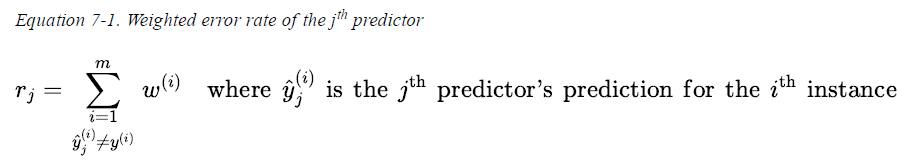

Trọng số của bộ dự đoán được tính như sau:

$\eta$: learning rate mặc định là 1

Dự đoán càng chính xác, trọng số càng cao. Nếu nó chỉ dự đoán ngẫu nhiên, trọng số sẽ gần với 0. Tuy nhiên nếu dự đoán đa số là sai (tệ hơn cả ngẫu nhiên), trọng số sẽ âm

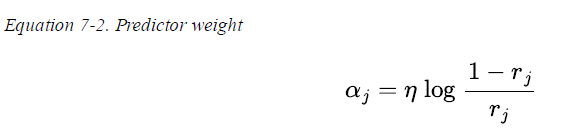

Tiếp theo thuật toán sẽ cập nhật trọng số của mẫu, thêm trọng số cho các mẫu bị missclassified (dự đoán sai)

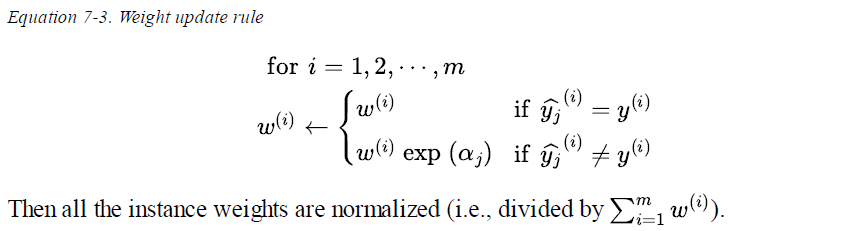

Thuật toán sẽ lặp lại và dừng lại khi đạt được số lượng bộ dự đoán mong muốn hoặc khi tìm thấy một bộ dự đoán hoàn hảo

Để đưa ra dự đoán, AdaBoost đơn giản là tính toán dự đoán của tất cả các bộ dự đoán, sau đó gán trọng số cho chúng dựa trên trọng số $\alpha_j$ của từng bộ dự đoán. Lớp được dự đoán sẽ là lớp nhận được tổng số phiếu bầu có trọng số cao nhất.

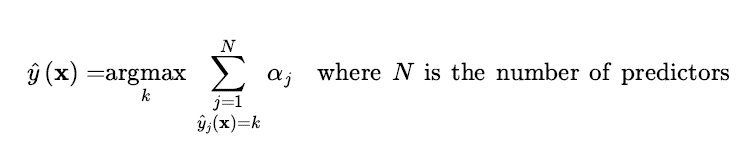

In [38]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=30,
learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

accuracy_score(ada_clf.predict(X_test), y_test)

#If your AdaBoost ensemble is overfitting the training set, 
# you can try reducing the number of estimators or more strongly regularizing the base estimator.

c:\Users\Hiep\.conda\envs\data_eng\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


0.904

## Gradient Boosting

Một thuật toán boosting rất phổ biến khác là *gradient boosting*. Như AdaBoost, gradient boosting hoạt động bằng cách tuần tự thêm các bộ dự đoán vào tập hợp, mỗi cái chính xác hơn cái trước. Tuy nhiên, thay vì điều chỉnh trọng số của các mẫu huấn luyện ở mỗi vòng lặp như cách mà AdaBoost thực hiện, phương pháp này cố gắng huấn luyện bộ dự đoán mới để phù hợp với sai số dư (residual errors) mà bộ dự đoán trước đó đã mắc phải.

Một ví dụ hồi quy đơn giản, sử dụng decision trees như bộ dự đoán cơ sở; nó được gọi là *gradient tree boosting*, hoặc *gradient boosted regression trees* (GBRT).

In [39]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

# create data
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100) # y = 3x^2 + noise

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

# second model on residual errors made by the first predictor
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=43)
tree_reg2.fit(X, y2)

# continuous
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=44)
tree_reg3.fit(X, y3)


DecisionTreeRegressor(max_depth=2, random_state=44)

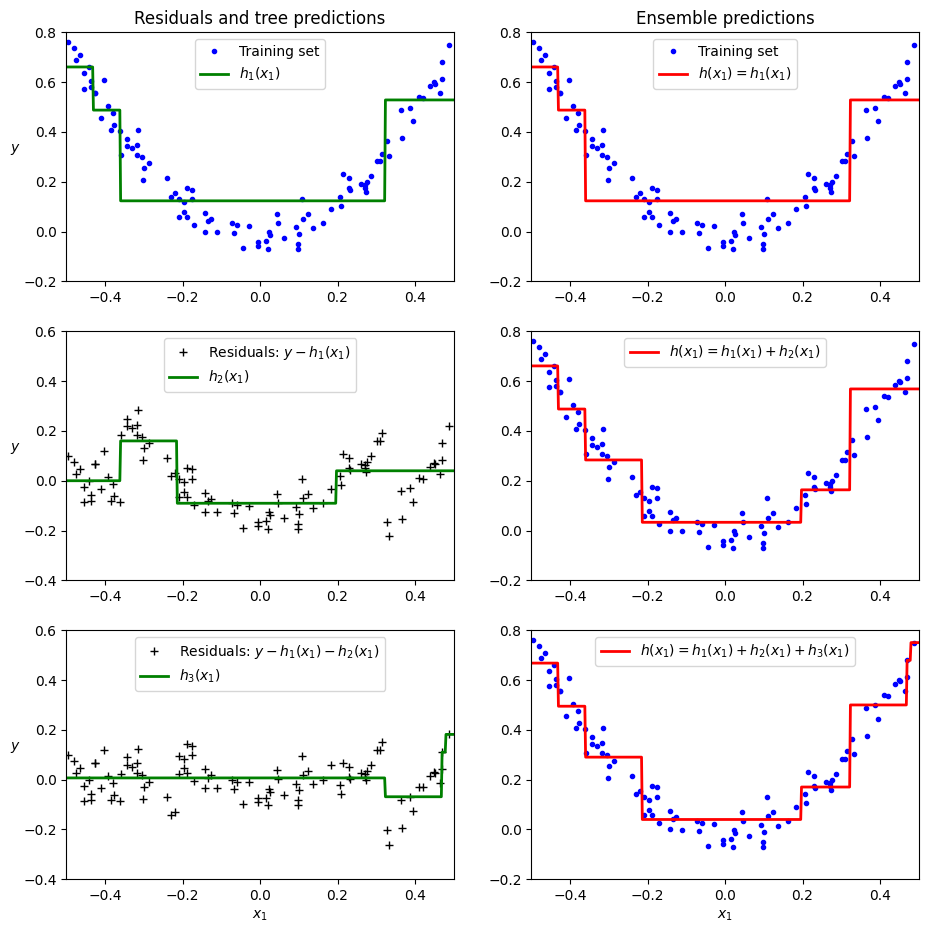

In [42]:
def plot_predictions(regressors, X, y, axes, style,
                     label=None, data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)

    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center")
    plt.axis(axes)

plt.figure(figsize=(11, 11))

plt.subplot(3, 2, 1)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="g-",
                 label="$h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$  ", rotation=0)
plt.title("Residuals and tree predictions")

plt.subplot(3, 2, 2)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.title("Ensemble predictions")

plt.subplot(3, 2, 3)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_2(x_1)$", data_style="k+",
                 data_label="Residuals: $y - h_1(x_1)$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 4)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.2, 0.8],
                  style="r-", label="$h(x_1) = h_1(x_1) + h_2(x_1)$")

plt.subplot(3, 2, 5)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_3(x_1)$", data_style="k+",
                 data_label="Residuals: $y - h_1(x_1) - h_2(x_1)$")
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 6)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y,
                 axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$")

plt.show()

Hình bên trái là decision boundary của mỗi cây trên bộ dữ liệu sai số dư của các cây trước đó, hình bên phải decision boundary của tập hợp cây.

- Ở hàng đầu tập hợp chỉ có 1 cây nên kết quả sẽ giống nhau
- Ở hàng thứ hai kết quả là sự tổng hợp của cây 1 và 2
- Tương tự với hàng thứ 3

=> Có thể thấy rằng tập hợp dự đoán tốt hơn khi thêm các cây mới vào

In [43]:
# use Scikit-Learn’s GradientBoostingRegressor class to train GBRT ensembles more easily

from sklearn.ensemble import GradientBoostingRegressor
gbrt = GradientBoostingRegressor(
    max_depth=2, n_estimators=3,
    learning_rate=1.0, random_state=42
)

gbrt.fit(X, y)


GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [57]:

gbrt2 = GradientBoostingRegressor(
    max_depth=2, n_estimators=92,
    learning_rate=0.05, random_state=42
)

gbrt2.fit(X, y)

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=92,
                          random_state=42)

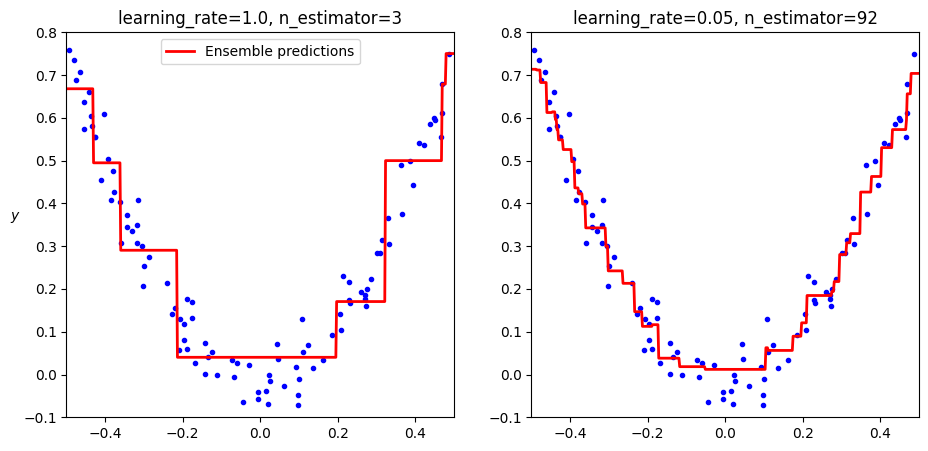

In [58]:
plt.figure(figsize=(11, 5))
plt.subplot(1, 2, 1)
plt.title("learning_rate=1.0, n_estimator=3")
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-",
                 label="Ensemble predictions", data_style="b.")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(1, 2, 2)
plt.title("learning_rate=0.05, n_estimator=92")
plot_predictions([gbrt2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-",
                 data_style="b.",
                 )


`learning_rate` sẽ chia tỉ lệ đóng góp của mỗi cây, tức là nếu `learning_rate` nhỏ, ta sẽ cần nhiều cây hơn để khớp với training set nhưng thường sẽ khái quát tốt hơn

Khi `n_iter_no_change` được thiết lập, phương thức `fit()` sẽ tự động chia tập huấn luyện thành một tập huấn luyện nhỏ hơn và một tập kiểm tra (validation set). Điều này cho phép đánh giá hiệu suất của mô hình mỗi khi thêm một cây mới. Kích thước của tập kiểm tra được kiểm soát bởi siêu tham số `validation_fraction`, mặc định là 10%. Siêu tham số `tol` xác định mức cải thiện hiệu suất tối thiểu mà vẫn được xem là không đáng kể. Giá trị mặc định là 0.0001.

Lớp `GradientBoostingRegressor` cũng hỗ trợ siêu tham số subsample, cho phép chỉ định tỉ lệ mẫu huấn luyện được sử dụng để huấn luyện mỗi cây. Ví dụ, nếu subsample=0.25, thì mỗi cây chỉ được huấn luyện trên 25% số mẫu huấn luyện, được chọn ngẫu nhiên. Kỹ thuật này đánh đổi việc tăng độ lệch (bias) để giảm phương sai (variance). Nó cũng giúp tăng tốc quá trình huấn luyện một cách đáng kể. Kỹ thuật này được gọi là stochastic gradient boosting.

## Histogram-Based Gradient Boosting (HGB)

Là một cách triển khai khác của GBRT, tối ưu hơn với bộ dữ liệu lớn. Hoạt động bằng cách. Kỹ thuật này hoạt động bằng cách chia các feature đầu vào thành các nhóm (binning) và thay thế chúng bằng các số nguyên. Số lượng nhóm được kiểm soát bởi siêu tham số max_bins, mặc định là 255 và không thể đặt lớn hơn giá trị này. Việc phân nhóm (binning) có thể giảm đáng kể số lượng ngưỡng cần được đánh giá trong quá trình huấn luyện. Hơn nữa, làm việc với số nguyên cho phép sử dụng các cấu trúc dữ liệu nhanh hơn và tiết kiệm bộ nhớ hơn. Ngoài ra, cách tạo các nhóm (bins) giúp loại bỏ nhu cầu sắp xếp các đặc trưng khi huấn luyện mỗi cây.

Với kỹ thuật này độ phức tạp là $O(b \times m)$ thay vì $O(n \times m \times log(m))$, $b$ là số nhóm (bins), $m$ là số lượng mẫu, $n$ là số features. Tức là HGB có thể huấn luyện nhanh hơn gấp 100 lần so với GBRT với bộ dữ liệu lớn. Tuy nhiên phân nhóm có thể làm độ chính xác giảm 

Một số điểm khác của `HistGradientBoostingRegressor` với `GradientBoostingRegressor`: 
- Early stopping tự động hoạt động nếu số mẫu lớn hơn 10000
- Không hỗ trợ subsampling
- `max_iter` thay vì `n_estimator` (chỉ đổi tên)
- Chỉ hỗ trợ điều khiển cây bằng các tham số `max_leaf_nodes`, `min_samples_leaf`, `max_depth`

# Stacking

Phương pháp tổ hợp cuối cùng mà chúng ta sẽ thảo luận trong chương này được gọi là **stacking** (viết tắt của s*tacked generalization*). Nó dựa trên một ý tưởng đơn giản: thay vì sử dụng các hàm đơn giản (hard voting) để tổng hợp các dự đoán từ tất cả các mô hình trong tổ hợp, sẽ huấn luyện một mô hình để thực hiện việc tổng hợp này?

Hình dưới minh họa một tổ hợp như vậy đang thực hiện tác vụ hồi quy trên một mẫu mới


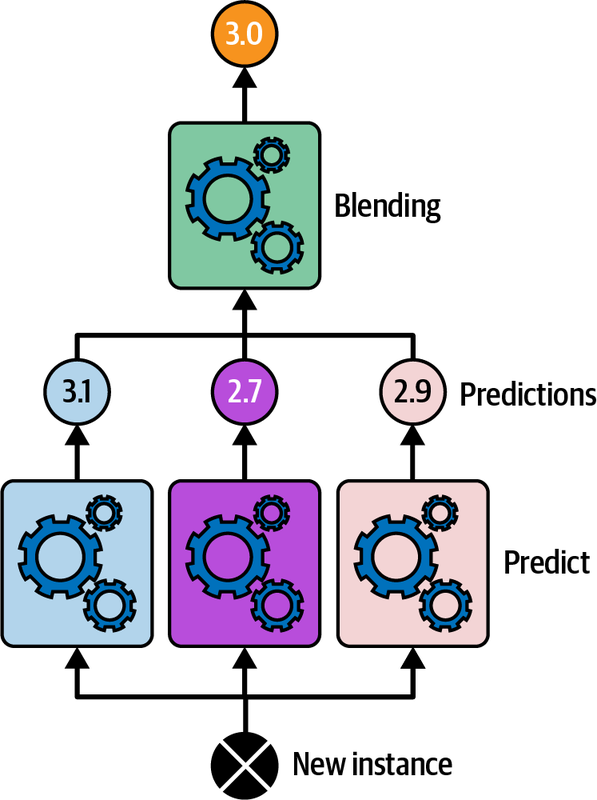

Mỗi bộ dự đoán ở dưới dự đoán một kết quả khác nhau (3.1, 2.7, 2.9), và sau đó bộ dự đoán cuối cùng (được gọi là `blender` hoặc một `meta learner`) lấy các dự đoán trước đó làm inputs để thực hiện dự đoán kết quả cuối cùng

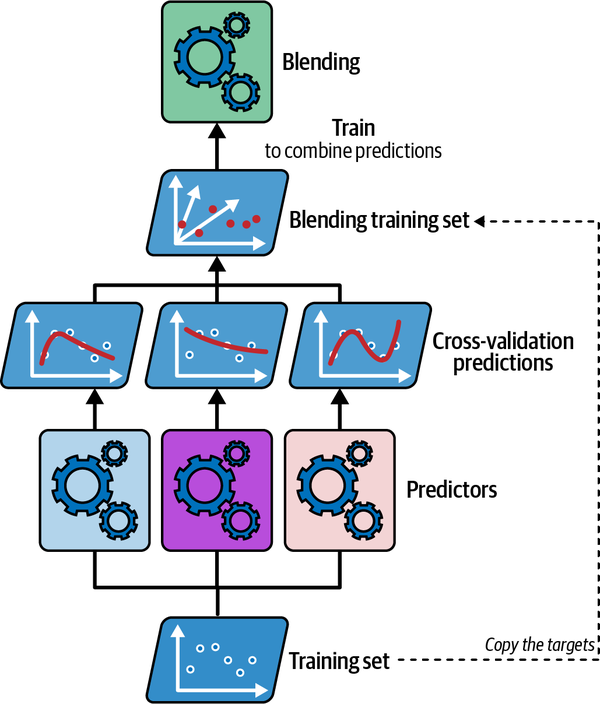 | 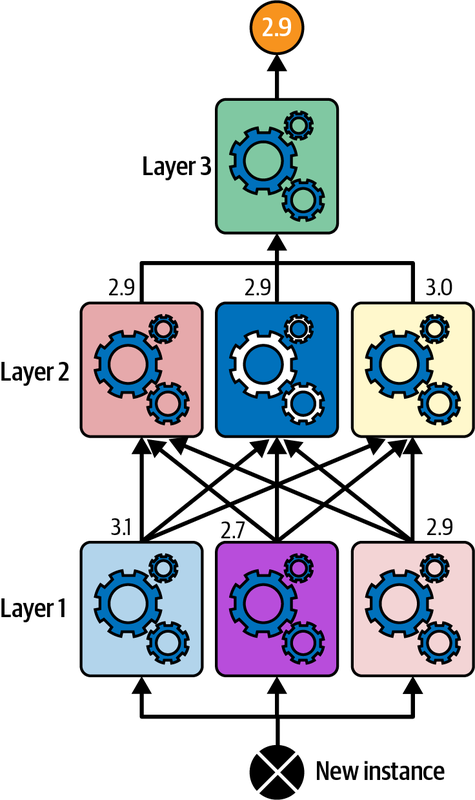

Để huấn luyện một `blender`, trước hết ta cần xây dựng training set cho quá trình blending. Ta có thể sử dụng hàm `cross_val_predict()` trên mỗi mô hình trong tổ hợp để lấy các dự đoán ngoài tập huấn luyện (out-of-sample) cho từng mẫu trong tập huấn luyện gốc. Các dự đoán này sẽ được sử dụng làm đặc trưng đầu vào để huấn luyện blender; còn nhãn mục tiêu (target) thì có thể giữ nguyên từ tập huấn luyện ban đầu. Sau khi `blender` được huấn luyện, các mô hình cơ sở (base predictors) sẽ được huấn luyện lại một lần cuối trên toàn bộ tập huấn luyện gốc.

In [ ]:
# we can replace the VotingClassifier with a StackingClassifier:

from sklearn.ensemble import StackingClassifier
stacking_clf = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(probability=True, random_state=42))
    ],
    final_estimator=RandomForestClassifier(random_state=43),
    cv=5  # number of cross-validation folds
)
stacking_clf.fit(X_train, y_train)

# Exercises

## 1

**Question: If you have trained five different models on the exact same training data, and they all achieve 95% precision, is there any chance that you can combine these models to get better results? If so, how? If not, why?**

Thường chúng sẽ mang lại kết quả tốt hơn, sẽ tốt hơn nữa nếu các mô hình rất khác nhau (SVMClassifier, Decision Tree, Logicstic Regression Classifier, ..). Nó thậm chí còn tốt hơn nếu chúng được đào tạo trên các trường hợp đào tạo khác nhau (như bagging và pasting)

## 4

**Question: What is the benefit of out-of-bag evaluation**

Với đánh giá out-of-bag, mỗi dự đoán trong một tập hợp bagging được đánh giá bằng cách sử dụng các trường hợp mà nó không được đào tạo. Điều này giúp có thể có một đánh giá khá khách quan về tập hợp mà không cần một bộ xác thực bổ sung. Do đó, bạn có nhiều trường hợp hơn để đào tạo và tập hợp của bạn có thể hoạt động tốt hơn một chút.

## 5

**Question: What makes extra-trees ensembles more random than regular random forests? How can this extra randomness help? Are extra-trees classifiers slower or faster than regular random forests?**

Khi phát triển cây chỉ có một tập hợp con ngẫu nhiên của các đặc trưng được xem xét để phân tách ở mỗi nút. Điều này tương tự ở cả Random Forest và Extra-trees, nhưng thay vì tìm kiếm ngưỡng tốt nhất như Decision Tree thường làm, Extra-trees sử dụng ngưỡng ngẫu nhiên cho mỗi đặc trưng. Sự ngẫu nhiên thêm này hoạt động giống như một hình thức regularization: Nếu Random Forest bị overfitting, Extra-trees có thể hoạt động tốt hơn. Hơn nữa, vì những cây ngoài không tìm kiếm các ngưỡng tốt nhất có thể, nên chúng train nhanh hơn nhiều so với Random Forests. Con khi đưa ra dự đoán thì tương tự nhau

## 6

**Question: If your AdaBoost ensemble underfits the training data, which hyperparameters should you tweak, and how?**

Tăng số lượng estimator hoặc giảm các regularization hyperparameters của bộ dự đoán cơ sở. Hoặc có thể tăng learning_rate một chút


## 7

**Question: If your gradient boosting ensemble overfits the training set, should you increase or decrease the learning rate?**

Có thể giảm learning_rate, sử dụng early stopping để tìm đúng số bộ dự đoán cần thiết (có thể overfit do quá nhiều bộ dự đoán)

## 8

**Question: Load the MNIST dataset, and split it into a training set, a validation set, and a test set (e.g., use 50,000 instances for training, 10,000 for validation, and 10,000 for testing). Then train various classifiers, such as a random forest classifier, an extra-trees classifier, and an SVM classifier. Next, try to combine them into an ensemble that outperforms each individual classifier on the validation set, using soft or hard voting. Once you have found one, try it on the test set. How much better does it perform compared to the individual classifiers?**

In [26]:
from sklearn.datasets import fetch_openml

X_mnist, y_mnist = fetch_openml('mnist_784', return_X_y=True, as_frame=False, parser='auto')
X_train, y_train = X_mnist[:50000], y_mnist[:50000]
X_valid, y_valid = X_mnist[50_000:60_000], y_mnist[50_000:60_000]
X_test, y_test = X_mnist[60_000:], y_mnist[60_000:]

In [27]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier


In [28]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
extra_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
svm_clf = LinearSVC(max_iter=1000, tol=20, dual=True, random_state=42)
mlp_clf = MLPClassifier(random_state=42)

In [29]:
estimators = [rf_clf, extra_clf, svm_clf, mlp_clf]

for estimator in estimators:
    print(f"Train: ", estimator)
    estimator.fit(X_train, y_train)

Train:  RandomForestClassifier(random_state=42)
Train:  ExtraTreesClassifier(random_state=42)
Train:  LinearSVC(dual=True, random_state=42, tol=20)
Train:  MLPClassifier(random_state=42)


In [30]:
[estimator.score(X_valid, y_valid) for estimator in estimators]

[0.9736, 0.9743, 0.8662, 0.9643]

In [31]:
named_estimators = [
    ('rf', rf_clf),
    ('extra', extra_clf),
    ('svm', svm_clf),
    ('mlp', mlp_clf)
]

In [32]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(estimators=named_estimators)

In [33]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('extra', ExtraTreesClassifier(random_state=42)),
                             ('svm',
                              LinearSVC(dual=True, random_state=42, tol=20)),
                             ('mlp', MLPClassifier(random_state=42))])

In [34]:
voting_clf.score(X_valid, y_valid)

0.975

The VotingClassifier made a clone of each classifier, and it trained the clones using class indices as the labels, not the original class names. Therefore, to evaluate these clones we need to provide class indices as well. To convert the classes to class indices, we can use a LabelEncoder:

In [35]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_valid_encoded = encoder.fit_transform(y_valid)
y_valid_encoded


array([3, 8, 6, ..., 5, 6, 8])

Because this is mnist, the labels is digits, so it's simpler to just convert the class names to integers, since the digits match the class ids:

In [36]:
import numpy as np

y_valid_encoded = y_valid.astype(np.int64)
y_valid_encoded

array([3, 8, 6, ..., 5, 6, 8])

In [37]:
[estimator.score(X_valid, y_valid_encoded) for estimator in voting_clf.estimators_]

[0.9736, 0.9743, 0.8662, 0.9643]

In [38]:
# try remove SVM from ensemble

voting_clf.set_params(svm="drop") # use name is defined in named_estimators

VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('extra', ExtraTreesClassifier(random_state=42)),
                             ('svm', 'drop'),
                             ('mlp', MLPClassifier(random_state=42))])

In [39]:
# verify
voting_clf.estimators

[('rf', RandomForestClassifier(random_state=42)),
 ('extra', ExtraTreesClassifier(random_state=42)),
 ('svm', 'drop'),
 ('mlp', MLPClassifier(random_state=42))]

In [ ]:
voting_clf.score(X_valid, y_valid)

0.975

: 